# Pixel Based Metrics for Classification

In this notebook, the following pixel-based statistical features are calculated.
Images are then tried to be classified based on these features.

#### Computed Features
* Range, mean, std on red, green and blue channel
* range, mean, std on magnitude of Sobel gradients for r, g and b channel
* Energy, correlation, homogeneity on GLCM of grayscale image

In [1]:
import numpy as np
import pandas as pd
from os.path import join
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

import utils

from scipy.ndimage import sobel
from skimage import io
from skimage.color import rgb2gray

In [2]:
# Choose an arbitrary example image
train_dir = join('..', '..', 'data', 'curated', 'roofs_train')
materials = {'concrete_cement':0, 'healthy_metal':1, 'incomplete':2, 'irregular_metal':3, 'other':4}

## 1. Image Overview

### 1.1 Image Channels and Gradient Magnitude Image

In [ ]:
train_sample = join(train_dir, 'other', '7a307a06.tif')
img = io.imread(train_sample)

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (16, 5))

for k in [ax1, ax2, ax3, ax4]:
    k.axes.get_xaxis().set_visible(False)
    k.axes.get_yaxis().set_visible(False)

ax1.imshow(img, cmap='gray')
ax1.set_title("Original")
ax2.imshow(img[:, :, 0], cmap='Reds')
ax2.set_title("Red")
ax3.imshow(img[:, :, 1], cmap='Greens')
ax3.set_title("Green")
ax4.imshow(img[:, :, 2], cmap='Blues')
ax4.set_title("Blue")
fig.suptitle("Channels original image")
plt.show()

### 1.2 Gradient Magnitude Images based on Sobel

In [ ]:
def sobel_layers(img):
    sob = np.zeros(img.shape)    
    for layer in range(img.shape[2]):
        sx = sobel(img[:, :, layer].astype('int32'), axis=0, mode='constant')
        sy = sobel(img[:, :, layer].astype('int32'), axis=1, mode='constant')
        sob[:, :, layer] = np.hypot(sx, sy)
    return sob

In [ ]:
sob = sobel_layers(img)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16, 5))

for k in [ax1, ax2, ax3]:
    k.axes.get_xaxis().set_visible(False)
    k.axes.get_yaxis().set_visible(False)

    
ax1.imshow(sob[:, :, 0], cmap='Reds')
ax1.set_title("Red")
ax2.imshow(sob[:, :, 1], cmap='Greens')
ax2.set_title("Green")
ax3.imshow(sob[:, :, 2], cmap='Blues')
ax3.set_title("Blue")
fig.suptitle("Gradient magnitudes with Sobel filtering on channels")
plt.show()

## 2. Basic Statistics on Original and Sobel

In [ ]:
def statistics(img, sob):
    """ 
    Expects image as numpy array.
    Calculates basic image statistics (variance, std, range, mean)
    """
    # Select only those pixels that belong to the roof (i.e. mask the image)
    img_arr = img[:, :, :3][img[:, :, 3] > 0]

    mean_rgb = img_arr.mean(0)
    std_rgb = img_arr.std(0)
    ptp_rgb = img_arr.ptp(0) #peak-to-peak = range
    
    # Calculate statistics on gradient (Sobel) image
    sob_arr = sob[:, :, :3][sob[:, :, 3] > 0]

    mean_sob = sob_arr.mean(0)
    std_sob = sob_arr.std(0)
    ptp_sob = sob_arr.ptp(0)

    return mean_rgb, std_rgb, ptp_rgb, mean_sob, std_sob, ptp_sob
    

In [ ]:
statistics(img, sob)

## 3. GLCM features

For textural features, convert the image to grayscale and calculate energy, correlation and homogeneity features

In [ ]:
from skimage import io, color, img_as_ubyte
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics.cluster import entropy

def glcm_feats(img):
    grayImg = img_as_ubyte(color.rgb2gray(img))

    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    properties = ['energy', 'correlation', 'homogeneity']

    glcm = greycomatrix(grayImg, 
                        distances=distances, 
                        angles=angles,
                        symmetric=True,
                        normed=True)
    glcm_en = greycoprops(glcm, 'energy')
    glcm_co = greycoprops(glcm, 'correlation')
    glcm_ho = greycoprops(glcm, 'homogeneity')
    
    return glcm_en, glcm_co, glcm_ho

In [ ]:
glcm_feats(img)

## 4. Compute above Features on all labeled images

Walk through all images, compute the features and collect them in a Pandas Dataframe

In [3]:
#train_dir = join('..', '..', 'data', 'data2', 'mixco_3', 'roofs_train')

In [4]:
def calculate_features(train_dir):
    
    # Initialize a dataframe for the features    
    columns = ['id', 'label',
               'mean_rgb', 'std_rgb', 'ptp_rgb',
               'mean_sob', 'std_sob', 'ptp_sob',
               'glcm_en', 'glcm_co', 'glcm_ho']
    df_features = pd.DataFrame(columns=columns)

    data = []
    # Walk through all images
    for material in materials.keys():
        material_fp = join(train_dir, material)
        print(material_fp)
        for root, dirs, files in os.walk(material_fp):
            for file in files:
                img_fp = join(material_fp, file)
                label = materials[material]
                id = file.split('.')[0] # retrieve id from filename
                print(id, "labeled as", material, ":", label)
                
                img = io.imread(img_fp)
                sob = sobel_layers(img)
                
                mean_rgb, std_rgb, ptp_rgb, mean_sob, std_sob, ptp_sob = statistics(img, sob)
                glcm_en, glcm_co, glcm_ho = glcm_feats(img)

                data.append({'id': id ,
                             'mean_r': mean_rgb[0], 'mean_g': mean_rgb[1], 'mean_b': mean_rgb[2],
                             'std_r': std_rgb[0], 'std_g': std_rgb[1], 'std_b': std_rgb[2],
                             'ptp_r': ptp_rgb[0], 'ptp_g': ptp_rgb[1], 'ptp_b': ptp_rgb[2],
                             'mean_sob_r': mean_sob[0], 'mean_sob_g': mean_sob[1], 'mean_sob_b': mean_sob[2],
                             'std_sob_r': std_sob[0], 'std_sob_g': std_sob[1], 'std_sob_b': std_sob[2],
                             'ptp_sob_r': ptp_sob[0], 'ptp_sob_g': ptp_sob[1], 'ptp_sob_b': ptp_sob[2],
                             'glcm_en': glcm_en, 'glcm_co': glcm_co, 'glcm_ho': glcm_ho,
                             'label': label})
    
    df_features = pd.DataFrame(data)
    return df_features

In [5]:
pickle_path = join('..', '..', 'pickles')
compute_anew = False

if compute_anew == True:
    pb_features = calculate_features(train_dir)
    with open(join(pickle_path, 'pb_features.pkl'), 'wb') as f:
        pickle.dump(pb_features, f)

## 5. Classification based on above features

In [3]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score

import matplotlib.pyplot as plt
import matplotlib

In [4]:
pickle_path = join('..', '..', 'pickles')
with open(join(pickle_path, 'pb_features.pkl'), 'rb') as f:
    pb_features = pickle.load(f)

Select features that shall be taken into account for the classification

In [5]:
selected_feats = ['mean_r', 'mean_g', 'mean_b',
                 'std_r', 'std_g', 'std_b',
                 'ptp_r', 'ptp_g', 'ptp_b',
                 'mean_sob_r', 'mean_sob_g', 'mean_sob_b',
                 'std_sob_r', 'std_sob_g', 'std_sob_b',
                 'ptp_sob_r', 'ptp_sob_g', 'ptp_sob_b']

In [6]:
feature_matrix = pb_features[selected_feats].to_numpy()
#feature_matrix = np.column_stack(feature_matrix).transpose()
scaler = StandardScaler()
scaler.fit(feature_matrix)
feature_matrix_scaled = scaler.transform(feature_matrix)

labels = pb_features['label'].to_numpy().astype('int')

In [7]:
features_train, features_test, labels_train, labels_test = train_test_split(feature_matrix_scaled,
                                                                            labels,
                                                                            test_size=0.33,
                                                                            random_state=42)

In [8]:
clf = svm.SVC(gamma='scale', probability=True, C=100, decision_function_shape='ovr')
clf.fit(features_train, labels_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

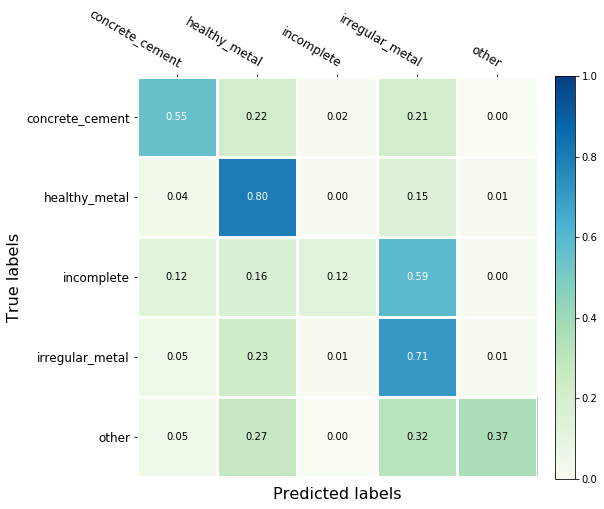

In [13]:
predicted_labels = clf.predict(features_test)
cm = confusion_matrix(labels_test, predicted_labels)

row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / row_sums

fig, ax = plt.subplots(figsize=(8.5, 8.5))
im, cbar = utils.heatmap(cm_norm,  materials.keys(), materials.keys(), ax=ax,
                         cmap="GnBu")
texts = utils.annotate_heatmap(im)

fig.tight_layout()
plt.show()

fname = join('..', 'documentation', 'figures', 'pixel_based_cm.png')
fig.savefig(fname)

## Calculate Statistical Scores With Cross Validation

In [ ]:
cv_results = cross_validate(clf, feature_matrix_scaled, labels,
                            cv=5, scoring=('f1_macro', 'f1_micro', 'accuracy', 'balanced_accuracy'),
                            n_jobs=7)

In [ ]:
cv_results

In [ ]:
f1_score(labels_test, predicted_labels, average=None)